# Word 2 Vector model

## CLeaning data

In [7]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

In [11]:
nlp = spacy.load('en')

In [2]:
df = pd.read_csv("./../data/reddit/cm/Masculism_comments.csv")

In [3]:
df.head()

,ID,Comment,Author,Score,Parent id,Publish Date
0,c2lqouq,It is important to realize *why* so much atten...,AHumanThatListens,5,t3_knu87,2011-09-22 09:57:33
1,c2lqp9j,There is also something else that's rarely bro...,[deleted],6,t3_knuah,2011-09-22 10:00:01
2,c2lqpvn,I wish this subreddit good luck. I hope this ...,junkeee999,6,t3_kntzz,2011-09-22 10:03:35
3,c2lqpwb,"Good point. Men are not ""sexualizable,"" right?...",AHumanThatListens,4,t1_c2lqp9j,2011-09-22 10:03:42
4,c2lqq9l,I think the more important point is that when ...,godlessaltruist,11,t1_c2lqouq,2011-09-22 10:05:36


In [503]:
df.loc[0].Comment

'It is important to realize *why* so much attention gets paid to female victims. The whole concept of the female gender in most societies is "the sexualizable gender." And that is a big problem, especially when coupled with the fact that they [women] are expected to carry most or all of the sexual responsibility (e.g, don\'t dress like a slut, don\'t get raped, don\'t get pregnant, it\'s your fault if you do, don\'t undersexualize yourself either, etc.) This is not expected of men in anywhere near the same degree, and all of society loses out because of that.\n\nHowever, once men are indeed sexualized, as is the case here, this is what happens. There is such a tight noose of homophobia collectively wringing our necks that, as it is said in the article, a lot of people can\'t even imagine a male being subject to sexual violence. Though this article speaks of a part of the world that is magnitudes more homophobic than pretty much any developed country, this still applies pretty much anyw

In [6]:
df.isnull().sum()

ID              0
Comment         0
Author          0
Score           0
Parent id       0
Publish Date    0
dtype: int64

In [16]:
df.shape

(14249, 6)

In [510]:
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]

    # Too short comments aren't so useful in the training
    if len(txt) > 2:
        return ' '.join(txt)

In [531]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['Comment'])

In [532]:
%%time
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

CPU times: user 2min 25s, sys: 23.2 s, total: 2min 48s
Wall time: 1min 54s


In [13]:
df_clean = pd.DataFrame({'clean': txt})
df_clean.shape

(14249, 1)

In [14]:
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(12734, 1)

In [508]:
df_clean.clean[0]

'important realize attention get pay female victim concept female gender society sexualizable gender big problem especially couple fact woman expect carry sexual responsibility e g dress like slut rape pregnant fault undersexualize etc expect man near degree society lose man sexualize case happen tight noose homophobia collectively wring neck say article lot people imagine male subject sexual violence article speak world magnitude homophobic pretty developed country apply pretty heartbreake'

## Creating the vocabulary

In [20]:
from gensim.models.phrases import Phrases, Phraser

In [52]:
sent = [row.split() for row in df_clean['clean']]

In [54]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [55]:
bigram = Phraser(phrases)

In [56]:
sentences = bigram[sent]

In [57]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

21938

In [58]:
sorted(word_freq, key=word_freq.get, reverse=True)[:11]

['man',
 'woman',
 'think',
 'feminist',
 'people',
 'like',
 'rape',
 "'",
 'say',
 'thing',
 'feminism']

## Starting the Model

In [90]:
import multiprocessing

from gensim.models import Word2Vec

In [91]:
cores = multiprocessing.cpu_count()
cores

16

In [92]:
w2v_model = Word2Vec(min_count=2,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [93]:
%%time
w2v_model.build_vocab(sentences, progress_per=10000)

CPU times: user 3.34 s, sys: 28 ms, total: 3.36 s
Wall time: 3.37 s


In [94]:
%%time
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

CPU times: user 3min 18s, sys: 1.11 s, total: 3min 19s
Wall time: 1min 37s


(8311380, 15990960)

## Some Analysis

In [95]:
w2v_model.init_sims(replace=True)

In [96]:
w2v_model.wv.most_similar(positive=["man"])

[('woman', 0.8259655833244324),
 ('structurally', 0.7188979983329773),
 ('victimize', 0.7095577716827393),
 ('gtman', 0.6805514097213745),
 ('gtwoman', 0.6772775650024414),
 ('supposedly', 0.6742631196975708),
 ('minimal', 0.6638935804367065),
 ('needy', 0.6635546088218689),
 ('lgbtq', 0.6602290868759155),
 ('receiver', 0.6591845750808716)]

In [117]:
w2v_model.wv.most_similar(positive=["mgtow"])

[('pua', 0.9059526920318604),
 ('incel', 0.8711636066436768),
 ('bitter', 0.8563239574432373),
 ('redpill', 0.8489885330200195),
 ('faction', 0.8479870557785034),
 ('homophobic', 0.8384590744972229),
 ('wary', 0.8337081670761108),
 ('vent', 0.8286869525909424),
 ('bash', 0.8209365606307983),
 ('vitriolic', 0.8129596710205078)]

In [98]:
w2v_model.wv.most_similar(positive=["incel"])

[('fling', 0.9197372794151306),
 ('moan', 0.9174047112464905),
 ('witty', 0.9127354621887207),
 ('flame', 0.9085283279418945),
 ('neckbeard', 0.9030858278274536),
 ('disgust', 0.900199830532074),
 ('excited', 0.8980779647827148),
 ('chill', 0.897413969039917),
 ('vitriolic', 0.8946410417556763),
 ('douchebag', 0.8921919465065002)]

In [179]:
w2v_model.wv.most_similar(positive=["mgtow"])

[('pua', 0.9059526920318604),
 ('incel', 0.8711636066436768),
 ('bitter', 0.8563239574432373),
 ('redpill', 0.8489885330200195),
 ('faction', 0.8479870557785034),
 ('homophobic', 0.8384590744972229),
 ('wary', 0.8337081670761108),
 ('vent', 0.8286869525909424),
 ('bash', 0.8209365606307983),
 ('vitriolic', 0.8129596710205078)]

In [100]:
w2v_model.wv.similarity("mra", "masculism")

0.6883935

In [101]:
w2v_model.wv.similarity("mra", "mgtow")

0.71136

In [102]:
w2v_model.wv.similarity("mra", "incel")

0.5894016

In [103]:
w2v_model.wv.similarity("incel", "mgtow")

0.8711634

In [104]:
w2v_model.wv.similarity("redpill", "mgtow")

0.8489885

In [105]:
w2v_model.wv.similarity("redpill", "mra")

0.71640015

In [106]:
w2v_model.wv.similarity("mra", "house")

-0.018870939

In [107]:
w2v_model.wv.similarity("man", "woman")

0.8259655

In [109]:
w2v_model.wv.doesnt_match(['incel', 'mgtow', 'mra', 'mensright'])

'mra'

In [124]:
w2v_model.wv.most_similar(positive=["masculism", "woman"], negative=["feminism"], topn=5)

[('man', 0.6640526056289673),
 ('gtman', 0.6519631743431091),
 ('chivalrous', 0.6417394876480103),
 ('expect', 0.6189891695976257),
 ('desirable', 0.6160820722579956)]

### gt means that the word comes from a sitatons, I will cut it from the model after

In [180]:
w2v_model.wv.most_similar(positive=["masculism", "woman"], negative=["feminism"], topn=5)

[('man', 0.6640526056289673),
 ('gtman', 0.6519631743431091),
 ('chivalrous', 0.6417394876480103),
 ('expect', 0.6189891695976257),
 ('desirable', 0.6160820722579956)]

## t-SNE visualizations:

In [183]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [499]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ["r"]

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word], topn=5)
    
    # adds the vector for each of the closest words to the array
    colors = ["#0A0A0A", "#00AA00", "#0000AA", "#AA0A0A", "#B000B0"]
    colors2 = [color.replace("0", "6") for color in colors]
    
    color_list.extend(colors)
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    count = 0;
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append(colors2[int(count/3)])
        arrays = np.append(arrays, wrd_vector, axis=0)
        
        count += 1
        
    # Reduces the dimensionality from 300 to 16 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [500]:
def tsne3_of_5(model, primary_word):
    top3s = []
    top5 = w2v_model.wv.most_similar(positive=[primary_word], topn=3)
    for child_word in top5:
        top3s.extend(t[0] for t in w2v_model.wv.most_similar(positive=[child_word], topn=5))

    tsnescatterplot(model, primary_word, top3s) #list(dict.fromkeys(top3s)))

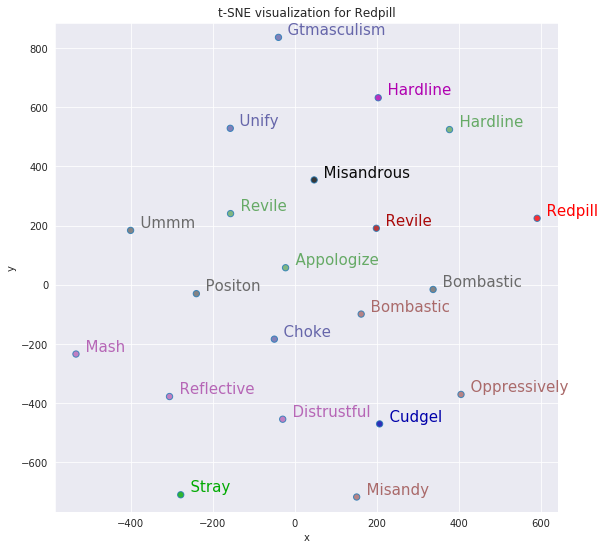

In [501]:
tsne3_of_5(w2v_model, "redpill")

# All subreddits data

#### Data created by the script word2vec.py

In [2]:
import pandas as pd
import pickle
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict  # For word frequency

In [3]:
with open("df_clean.csv", "rb") as fp:   # Unpickling
    df_clean = pickle.load(fp)

In [5]:
df_clean.shape

(11023346, 1)

Data with "gt" mean that it is a comment with quote block, normaly used to rewrite other comments, since it can "create" new words, those comments are deleted

In [8]:
df_clean = df_clean[~df_clean.clean.str.contains("gt")]

In [9]:
df_clean.shape

(9729119, 1)

#### Detecting Bigrams

As Phrases() takes a list of list of words as input:

In [10]:
sent = [row.split() for row in df_clean['clean']]

Creates the relevant phrases from the list of sentences:
* min_count ignore all words and bigrams with total collected count lower than this value.

In [11]:
phrases = Phrases(sent, min_count=30)

Transform the corpus based on the bigrams detected:

In [12]:
bigram = Phraser(phrases)

In [13]:
sentences = bigram[sent]

#### Most Frequent words

In [14]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

792302

In [17]:
print(sorted(word_freq, key=word_freq.get, reverse=True)[:20])

['woman', 'like', 'man', 'think', 'people', 'want', 'know', 'good', 'time', 'get', 'thing', 'guy', 'girl', 'look', 'fuck', 'go', 'way', 'work', 'life', 'say']


## Training the model

In [324]:
import multiprocessing

from gensim.models import Word2Vec

In [325]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

Parameters:

* min_count – Ignores all words with total frequency lower than this. (2, 100)
* window – Maximum distance between the current and predicted word within a sentence. E.g. window words to the left and to the right (2, 10)
* size – Dimensionality of the word vectors. (50, 300)
* sample – The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).
* alpha – The initial learning rate. (0.01, 0.05)
* min_alpha – Learning rate will linearly drop to min_alpha as training progresses. alpha - (min_alpha * epochs) ~ 0.00
* negative – If > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.
* workers – Use these many worker threads to train the model (=faster training with multicore machines).

In [348]:
w2v_model1 = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

### using a small dataset 1% of the data -> first

#### Building the vocabulary table

In [349]:
%time w2v_model1.build_vocab(sentences[:100000])

CPU times: user 10.8 s, sys: 120 ms, total: 10.9 s
Wall time: 10.9 s


#### Training the model

* total_examples (int) – Count of sentences.
* epochs (int) – Number of iterations (epochs) over the corpus.

In [350]:
%time w2v_model1.train(sentences[:100000], total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

CPU times: user 10min 49s, sys: 7.77 s, total: 10min 57s
Wall time: 6min 9s


(26590687, 58773780)

init_sims()

* Precompute L2-normalized vectors.
* If replace is set, forget the original vectors and only keep the normalized ones = saves lots of memory.

In [351]:
w2v_model1.init_sims(replace=True)

## Exploring the model

In [352]:
w2v_model1.wv.most_similar(positive=["man"])

[('woman', 0.6790633797645569),
 ('small_minority', 0.4263498783111572),
 ('unwilling', 0.42337772250175476),
 ('bend_backwards', 0.4195219874382019),
 ('society', 0.41192132234573364),
 ('male', 0.39413076639175415),
 ('sexual_marketplace', 0.39393550157546997),
 ('desirable', 0.39245253801345825),
 ('facet', 0.3891860246658325),
 ('mating_strategy', 0.38775426149368286)]

In [353]:
w2v_model1.wv.most_similar(positive=["woman"])

[('man', 0.6790633797645569),
 ('high_smv', 0.45030856132507324),
 ('female', 0.4325144588947296),
 ('desirable', 0.4283517897129059),
 ('sexually', 0.4255073666572571),
 ('attractive', 0.4250008761882782),
 ('bend_backwards', 0.42277413606643677),
 ('small_minority', 0.4072626531124115),
 ('undesirable', 0.40437817573547363),
 ('raw_deal', 0.3950452208518982)]

In [354]:
w2v_model1.wv.most_similar(positive=["incel"])

[('low_smv', 0.45936477184295654),
 ('celibate', 0.4441908597946167),
 ('fa', 0.4199325442314148),
 ('virgin', 0.40931978821754456),
 ('frustrated', 0.38552629947662354),
 ('partner_count', 0.3778812885284424),
 ('lose_virginity', 0.352451354265213),
 ('mindset', 0.344082772731781),
 ('loser', 0.3346908688545227),
 ('purple_pill', 0.33461880683898926)]

In [355]:
w2v_model1.wv.most_similar(positive=["rape"])

[('sexual_assault', 0.6157021522521973),
 ('domestic_abuse', 0.5541081428527832),
 ('consensual_sex', 0.5531039834022522),
 ('rape_accusation', 0.532663881778717),
 ('file_false', 0.5270358324050903),
 ('pedophilia', 0.5212894678115845),
 ('accuse_rape', 0.5162450075149536),
 ('falsely_accuse', 0.5157549381256104),
 ('assault', 0.5063571929931641),
 ('guilty_prove', 0.4942812919616699)]

In [356]:
w2v_model1.wv.most_similar(positive=["mra", "woman"], negative=["feminism"], topn=5)

[('man', 0.41404396295547485),
 ('guy', 0.36568978428840637),
 ('friend_zone', 0.3543349504470825),
 ('attract', 0.3316401243209839),
 ('girl', 0.3188438415527344)]

### t-SNE visualizations

In [357]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [358]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 20 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

#### 10 Most similar X 10 Most disimilar

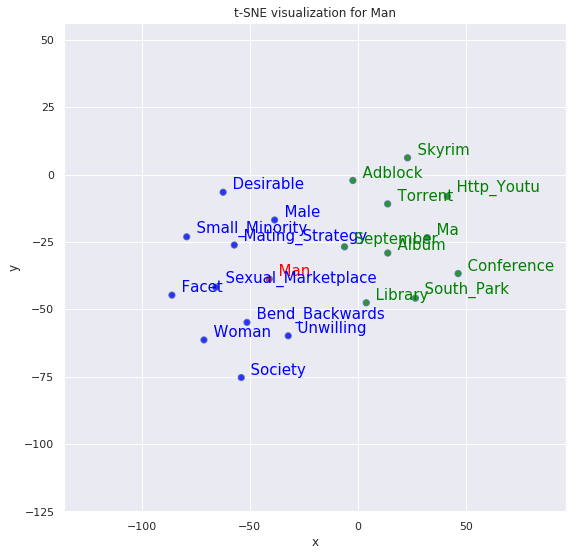

In [359]:
tsnescatterplot(w2v_model1, 'man', [i[0] for i in w2v_model1.wv.most_similar(negative=["man"])])

#### 10 Most similar words X 11th to 20th Most similar words:

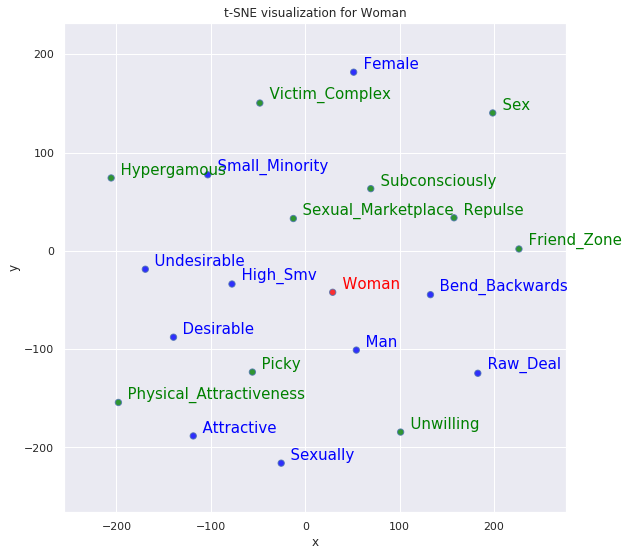

In [360]:
tsnescatterplot(w2v_model1, "woman", [t[0] for t in w2v_model1.wv.most_similar(positive=["woman"], topn=20)][10:])

### Visualizing 5 closest words and 3 closest words of those 5

In [361]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ["#FF0000"]

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word], topn=5)
    
    # adds the vector for each of the closest words to the array
    colors = ["#0A0A0A", "#00AA00", "#0000AA", "#AA0A0A", "#B000B0"]
    colors2 = [color.replace("0", "6") for color in colors]
    
    color_list.extend(colors)
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        arrays = np.append(arrays, wrd_vector, axis=0)

    
    # adds the vector for each of the words from list_names to the array
    count = 0;
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append(colors2[int(count/3)])
        arrays = np.append(arrays, wrd_vector, axis=0)
        
        count += 1
        
    # Reduces the dimensionality from 300 to 16 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [362]:
def tsne3_of_5(model, primary_word):
    top3s = []
    top5 = w2v_model.wv.most_similar(positive=[primary_word], topn=5)
    for child_word in top5:
        top3s.extend(t[0] for t in w2v_model.wv.most_similar(positive=[child_word], topn=3))

    tsnescatterplot(model, primary_word, top3s)

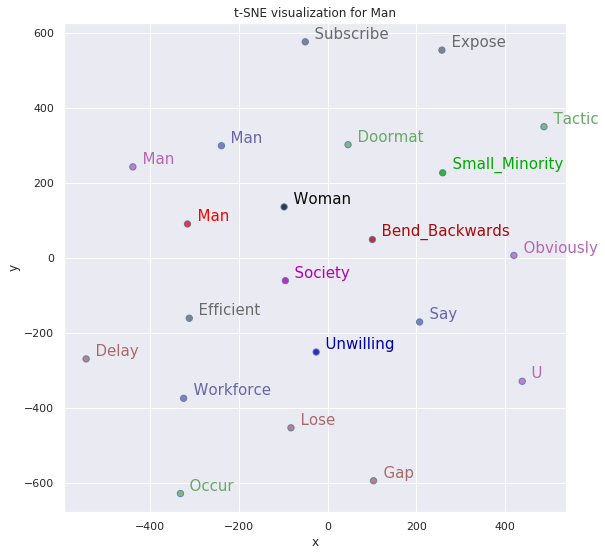

In [363]:
tsne3_of_5(w2v_model1, "man")

### Using graphs

In [364]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
sns.set()

In [365]:
def w2v_graph(model, word):
    G = nx.Graph()
    G.add_node(word)
    
    for close_word in model.wv.most_similar(positive=[word], topn=5):
        G.add_node(close_word[0])
        G.add_edge(word, close_word[0])
        
        for other_word in model.wv.most_similar(positive=[close_word[0]], topn=3):
            G.add_node(other_word[0])
            G.add_edge(close_word[0], other_word[0])
            
    plt.figure(figsize=(7, 7));
    nx.draw(G, with_labels=True, node_color = 'skyblue', font_size=15)

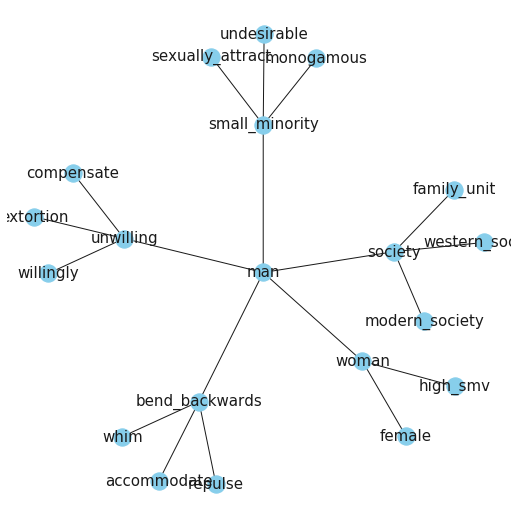

In [366]:
w2v_graph(w2v_model1, 'man')

### using a small dataset 10% of the data -> last

In [367]:
df_clean.shape

(9729119, 1)

In [368]:
w2v_model2 = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [369]:
w2v_model2.build_vocab(sentences[-100000:])

In [370]:
w2v_model2.train(sentences[-100000:], total_examples=w2v_model2.corpus_count, epochs=30, report_delay=1)

(25231176, 57728460)

In [371]:
w2v_model2.init_sims(replace=True)

### Comparing the first 1% with the last 1%

In [445]:
def comparing_models(model1, model2, word, title1='First 1%', title2='Last 1%'):
    G1 = nx.Graph()
    G2 = nx.Graph()
    G1.add_node(word)
    G2.add_node(word)
    
    for close_word in model1.wv.most_similar(positive=[word], topn=5):
        G1.add_node(close_word[0])
        G1.add_edge(word, close_word[0])
        
        for other_word in model1.wv.most_similar(positive=[close_word[0]], topn=3):
            G1.add_node(other_word[0])
            G1.add_edge(close_word[0], other_word[0])
            
    for close_word in model2.wv.most_similar(positive=[word], topn=5):
        G2.add_node(close_word[0])
        G2.add_edge(word, close_word[0])
        
        for other_word in model2.wv.most_similar(positive=[close_word[0]], topn=3):
            G2.add_node(other_word[0])
            G2.add_edge(close_word[0], other_word[0])
      
    plt.figure(figsize=(20, 17))
    
    plt.subplot(221, title=title1)
    nx.draw(G1, with_labels=True, node_color = 'skyblue', font_size=15)
    
    ax2 = plt.subplot(222, title=title2)
    nx.draw(G2, with_labels=True, node_color = 'skyblue', font_size=15)

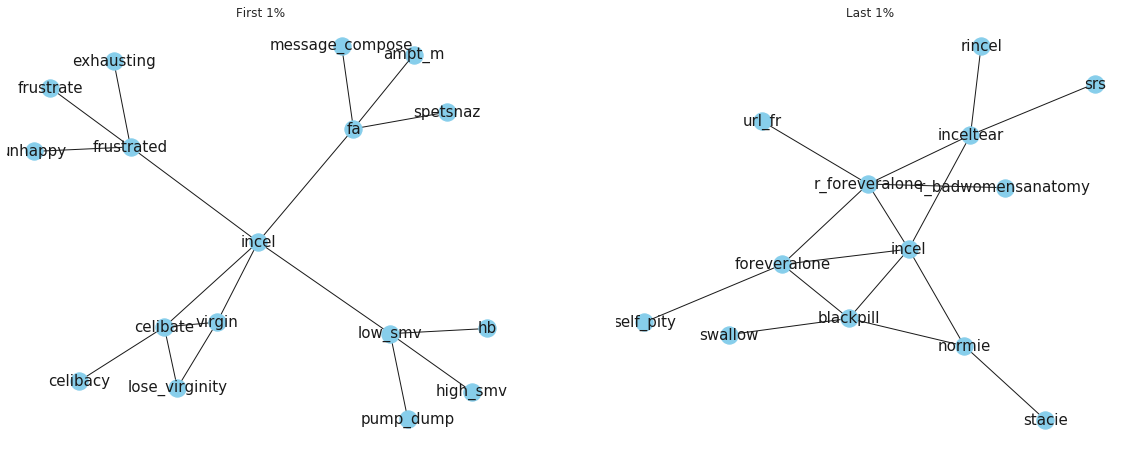

In [402]:
comparing_models(w2v_model1, w2v_model2, 'incel')

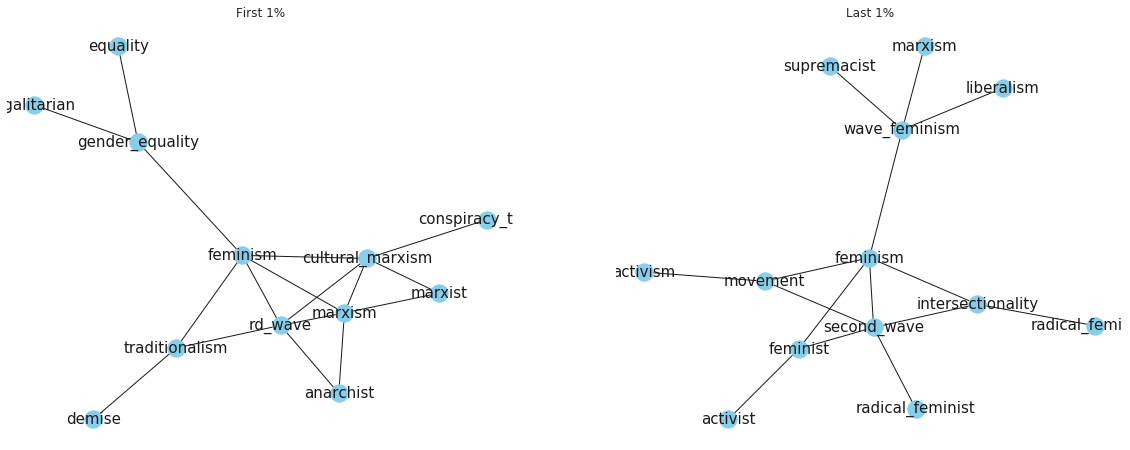

In [403]:
comparing_models(w2v_model1, w2v_model2, 'feminism')

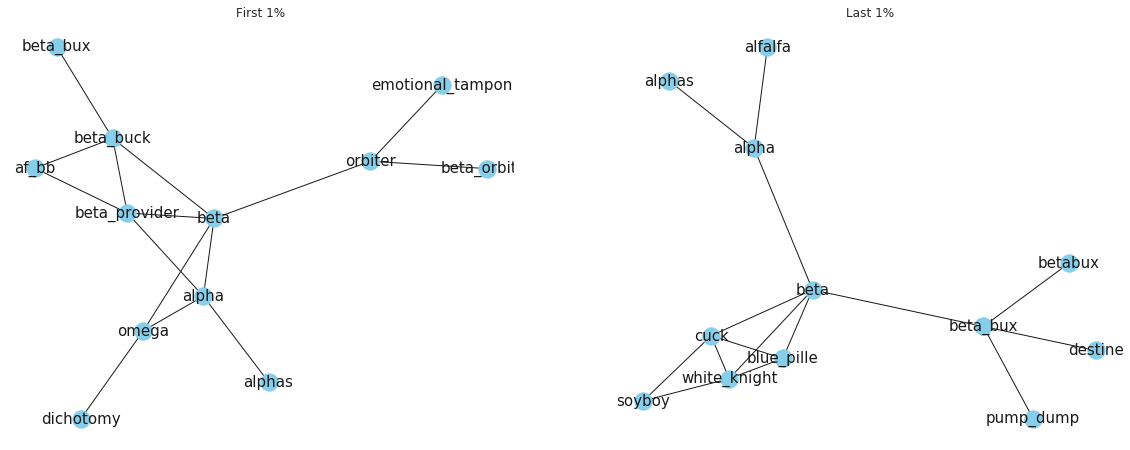

In [451]:
comparing_models(w2v_model1, w2v_model2, 'beta')

## Using 100% of the data

In [404]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [405]:
%time w2v_model.build_vocab(sentences)

CPU times: user 15min 34s, sys: 12.3 s, total: 15min 46s
Wall time: 15min 47s


In [406]:
%time w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

CPU times: user 21h 27min 43s, sys: 32min 27s, total: 22h 11s
Wall time: 10h 11min 9s


(2846541809, 5285651640)

In [407]:
w2v_model.init_sims(replace=True)

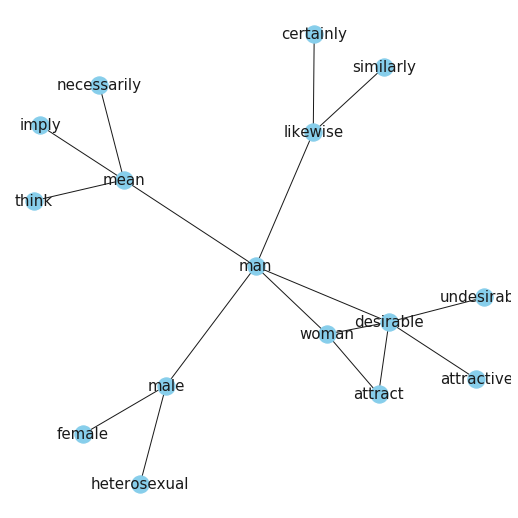

In [409]:
w2v_graph(w2v_model, 'man')

In [443]:
w2v_model.wv.most_similar(positive=["femoid"])

[('foid', 0.8692846894264221),
 ('roastie', 0.7231608033180237),
 ('feeeeemale', 0.5725647807121277),
 ('subhuman', 0.5624864101409912),
 ('feeemale', 0.5547305941581726),
 ('stacie', 0.5496423244476318),
 ('chad', 0.5388296842575073),
 ('feeeemale', 0.5363535284996033),
 ('wymyn', 0.5356521010398865),
 ('woman', 0.5319112539291382)]

In [430]:
w2v_model.wv.most_similar(positive=["man", "feminism"], negative=["woman"], topn=5)

[('feminist', 0.6951253414154053),
 ('wave_feminism', 0.6950789093971252),
 ('mrm', 0.6845601797103882),
 ('radical_feminism', 0.6825213432312012),
 ('movement', 0.679563045501709)]

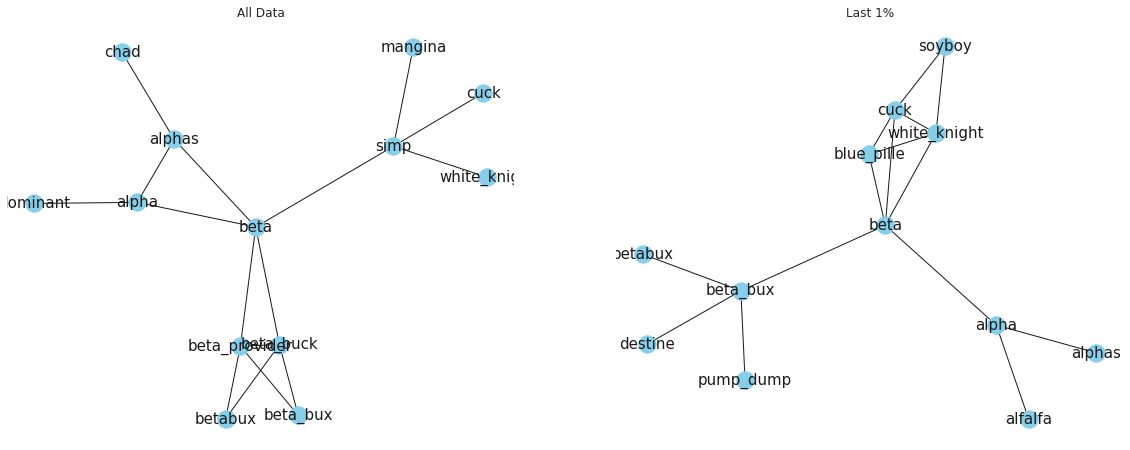

In [450]:
comparing_models(w2v_model, w2v_model2, 'beta', title1='All Data')